In [1]:
# Análise de Performance 

#-----------------------------------------------------------------------------
# Importa bibliotecas e define variáveis
#-----------------------------------------------------------------------------

import numpy as np
import pandas as pd
import scipy as sp
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as plc
import scipy.optimize as opt
from sklearn.neighbors import KernelDensity
import datetime

# Estilo dos gráficos
sns.set(color_codes = True)
plt.rcParams['figure.dpi'] = 300 # Resolução dos gráficos impressos no pdf (dpi)
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

params = {'legend.fontsize': 10,
          'legend.handlelength': 1}
plc.rcParams.update(params)

str_dir = 'C:/Users/nelly/Desktop/Mestrado Insper/DISSERTAÇÃO/Dissertação/1. Modelo/'


In [2]:
df_Brandt = pd.read_csv(str_dir + 'BRANDT_TESTE.csv')
df_Brandt.index = df_Brandt['indice']
df_Brandt = df_Brandt.drop(columns=['indice'])
df_Brandt = df_Brandt.dropna()
df_Brandt.index = df_Brandt.index.astype('datetime64[ns]')

df_Brandt_Direto = pd.read_csv(str_dir + 'BRANDT_INDICADORES_DIRETO.csv')
df_Brandt_Direto.index = df_Brandt_Direto['indice']
df_Brandt_Direto = df_Brandt_Direto.drop(columns=['indice'])
df_Brandt_Direto = df_Brandt_Direto.dropna()
df_Brandt_Direto.index = df_Brandt_Direto.index.astype('datetime64[ns]')

df_Markowitz = pd.read_csv(str_dir + 'MARKOWITZ.csv')
df_Markowitz.index = df_Markowitz['indice']
df_Markowitz = df_Markowitz.drop(columns=['indice'])
df_Markowitz = df_Markowitz.dropna()
df_Markowitz.index = df_Markowitz.index.astype('datetime64[ns]')

df_Contrarian = pd.read_csv(str_dir + 'CONTRARIAN.csv')
df_Contrarian.index = df_Contrarian['indice']
df_Contrarian = df_Contrarian.drop(columns=['indice'])
df_Contrarian = df_Contrarian.dropna()
df_Contrarian.index = df_Contrarian.index.astype('datetime64[ns]')

df_Momentum = pd.read_csv(str_dir + 'MOMENTUM.csv')
df_Momentum.index = df_Momentum['indice']
df_Momentum = df_Momentum.drop(columns=['indice'])
df_Momentum = df_Momentum.dropna()
df_Momentum.index = df_Momentum.index.astype('datetime64[ns]')

str_CDI = 'CDI'

df_cdi_retorno = pd.read_csv(filepath_or_buffer = str_dir + str_CDI + '.csv', sep=';')
df_cdi_retorno.index = df_cdi_retorno['Data']
df_cdi_retorno = df_cdi_retorno.drop(columns=['Data'])
df_cdi_retorno = df_cdi_retorno.dropna()

df_cdi_retorno['indice']=np.zeros(len(df_cdi_retorno.index))

In [ ]:
for x in range(0,len(df_cdi_retorno.index)):
    df_cdi_retorno.iloc[x,len(df_cdi_retorno.columns)-1] = datetime.datetime(df_cdi_retorno.iloc[x,2],df_cdi_retorno.iloc[x,1], df_cdi_retorno.iloc[x,0])

df_cdi_retorno = df_cdi_retorno.drop(columns=['Day', 'Month', 'Year'])
df_cdi_retorno.index = df_cdi_retorno['indice']
df_cdi_retorno = df_cdi_retorno.drop(columns=['indice'])

str_ibove = 'Ibove'

df_ibove_log_retorno = pd.read_csv(filepath_or_buffer = str_dir + str_ibove + '.csv', sep=';')
df_ibove_log_retorno.index = df_ibove_log_retorno['Data']
df_ibove_log_retorno = df_ibove_log_retorno.drop(columns=['Data'])
df_ibove_log_retorno = df_ibove_log_retorno.dropna()

df_ibove_log_retorno['indice']=np.zeros(len(df_ibove_log_retorno.index))

for x in range(0,len(df_ibove_log_retorno.index)):
    df_ibove_log_retorno.iloc[x,len(df_ibove_log_retorno.columns)-1] = datetime.datetime(df_ibove_log_retorno.iloc[x,2],df_ibove_log_retorno.iloc[x,1], df_ibove_log_retorno.iloc[x,0])

df_ibove_log_retorno = df_ibove_log_retorno.drop(columns=['Day', 'Month', 'Year'])
df_ibove_log_retorno.index = df_ibove_log_retorno['indice']
df_ibove_log_retorno = df_ibove_log_retorno.drop(columns=['indice'])


# Intersecção das séries de datas
data_fundo = pd.DataFrame(df_Brandt.index) # Todos os portfólios possuem a mesma série de datas
data_fundo = data_fundo.astype('datetime64[ns]')
data_cdi = pd.DataFrame(df_cdi_retorno.index)
data_ibove = pd.DataFrame(df_ibove_log_retorno.index)
data_int = data_fundo.merge(data_cdi, left_on = 'indice', right_on = 'indice')
data_int = data_int.merge(data_ibove, left_on = 'indice', right_on = 'indice')
df_cdi_retorno = df_cdi_retorno[df_cdi_retorno.index.isin(data_int['indice'])]
df_Brandt = df_Brandt[df_Brandt.index.isin(data_int['indice'])]
df_Brandt_Direto = df_Brandt_Direto[df_Brandt_Direto.index.isin(data_int['indice'])]
df_Markowitz = df_Markowitz[df_Markowitz.index.isin(data_int['indice'])]
df_ibove_log_retorno = df_ibove_log_retorno[df_ibove_log_retorno.index.isin(data_int['indice'])]
df_Contrarian = df_Contrarian[df_Contrarian.index.isin(data_int['indice'])]
df_Momentum = df_Momentum[df_Momentum.index.isin(data_int['indice'])]


df_cdi_log_retorno = np.log(1+df_cdi_retorno)
df_cdi_log_retorno.columns = ['CDI_Log_Retorno']
df_cdi_retorno_acum = np.exp(np.log(1+df_cdi_retorno).cumsum())-1
df_cdi_retorno_acum.columns = ['CDI_Retorno_Acum']

df_ibove_retorno = np.exp(df_ibove_log_retorno) - 1
df_ibove_retorno.columns = ['Ibove_Retorno']
df_ibove_retorno_acum = np.exp(np.log(1+df_ibove_retorno).cumsum())-1
df_ibove_retorno_acum.columns = ['Ibove_Retorno_Acum']

In [6]:
def MaxDD(r_cum):
    max2here = r_cum.expanding(min_periods=1).max()
    dd2here = (1+r_cum)/(1+max2here) - 1.0
    return dd2here.min()

def VaR_Hist(r_port, alfa):
    n = int(np.floor(len(r_port)*alfa))
    r_port_sorted = np.sort(r_port, axis = None)
    return r_port_sorted[n-1]

def VaR_NonPar(r_port, alfa, num_steps):
    n = len(r_port)
    cols = len(r_port.columns)
    res = pd.DataFrame(np.zeros([1,cols]))
    res.columns = r_port.columns
    for j in range(0,cols):
        if not np.isnan(r_port.iloc[0,j]):
            x = r_port.iloc[:,j]
            x = x[:,np.newaxis]
            avg = np.mean(x)
            vol = np.std(x)
            x_plot = np.linspace(-3.5*vol+avg, 3.5*vol+avg, num_steps) # Abrange um intervalo de 3.5 std - pode ajustar
            h = 1.06*vol*n**(-1/5) # Silverman's (1986) rule of thumb
            kde = KernelDensity(kernel='gaussian', bandwidth = h).fit(x)
            dens = np.exp(kde.score_samples(x_plot[:, np.newaxis]))
            cum_dens = sp.integrate.cumtrapz(y = dens, x = x_plot, initial = 0)
            res.iloc[0,j]=x_plot[len(cum_dens[cum_dens<=alfa])-1]
    return res

def CVaR_Hist(r_port, alfa):
    VaR = VaR_Hist(r_port, alfa)
    CVaR = np.mean(r_port[r_port<=VaR])
    return CVaR

def CVaR_NonPar(r_port, alfa, num_steps):
    n = len(r_port)
    cols = len(r_port.columns)
    res = pd.DataFrame(np.zeros([1,cols]))
    res.columns = r_port.columns
    for j in range(0,cols):
        if not np.isnan(r_port.iloc[0,j]):
            x = r_port.iloc[:,j]
            x = x[:,np.newaxis]
            avg = np.mean(x)
            vol = np.std(x)
            x_plot = np.linspace(-3.5*vol+avg, 3.5*vol+avg, num_steps) # Abrange um intervalo de 3.5 std - pode ajustar
            h = 1.06*vol*n**(-1/5) # Silverman's (1986) rule of thumb
            kde = KernelDensity(kernel='gaussian', bandwidth = h).fit(x)
            dens = np.exp(kde.score_samples(x_plot[:, np.newaxis]))
            cum_dens = sp.integrate.cumtrapz(y = dens, x = x_plot, initial = 0)
            res.iloc[0,j]=np.mean(x_plot[0:(len(cum_dens[cum_dens<=alfa])-1)])
    return res

def Omega(r_port, threshold, num_steps):
    n = len(r_port)
    cols = len(r_port.columns)
    res = pd.DataFrame(np.zeros([1,cols]))
    for j in range(0,cols):
        if not np.isnan(r_port.iloc[0,j]):
            x = r_port.iloc[:,j]
            x = x[:,np.newaxis]
            avg = np.mean(x)
            vol = np.std(x)
            x_plot = np.linspace(-3.5*vol+avg, 3.5*vol+avg, num_steps) # Abrange um intervalo de 3.5 std - pode ajustar
            x_plot_low = x_plot[x_plot<=threshold]
            x_plot_high = x_plot[x_plot>threshold]
            h = 1.06*vol*n**(-1/5) # Silverman's (1986) rule of thumb
            kde = KernelDensity(kernel='gaussian', bandwidth = h).fit(x)
            dens = np.exp(kde.score_samples(x_plot[:, np.newaxis]))
            cum_dens = sp.integrate.cumtrapz(y = dens, x = x_plot, initial = 0)
            try:
                int_low = sp.integrate.simps(cum_dens[x_plot<=threshold], x_plot_low)
                int_high = sp.integrate.simps(cum_dens[x_plot>threshold], x_plot_high)
                res.iloc[0,j]=((np.max(x_plot)-threshold)-int_high)/int_low
            except:
                res.iloc[0,j]=np.nan
    return res

# Sharpe generalizado - Zakamouline e Koekebakker (2009)
def ASKSR(r_port, rf):
    avg = np.mean(r_port)[0]
    var = np.var(r_port)[0]
    skew = sp.stats.skew(r_port)[0]
    kurt = sp.stats.kurtosis(r_port, fisher = False)[0]
    alfa = 3*np.sqrt(3*kurt-4*skew**2-9)/(var*(3*kurt-5*skew**2-9))
    beta = 3*skew/(np.sqrt(var)*(3*kurt-5*skew**2-9))
    eta = avg - 3*skew*np.sqrt(var)/(3*kurt-4*skew**2-9)
    delta = 3*np.sqrt(var)*np.sqrt(3*kurt-5*skew**2-9)/(3*kurt-4*skew**2-9)
    phi = np.sqrt(alfa**2-beta**2)
    a = (beta+alfa*(eta-rf)/np.sqrt(delta**2+(eta-rf)**2))
    return np.sqrt(2*(a*(eta-rf)-delta*(phi-np.sqrt(alfa**2-(beta-a)**2))))

def calc_beta(ret_fundo, ret_bench):
    df_aux = pd.concat([ret_fundo, ret_bench], axis =1)
    cov_fundo_bench = df_aux.cov().iloc[0,1]
    sigma_bench = np.std(ret_bench, ddof = 1)[0]
    beta = cov_fundo_bench / (sigma_bench**2)
    return beta

Text(0.5, 1.0, 'Cumulative Returns Since Inception')

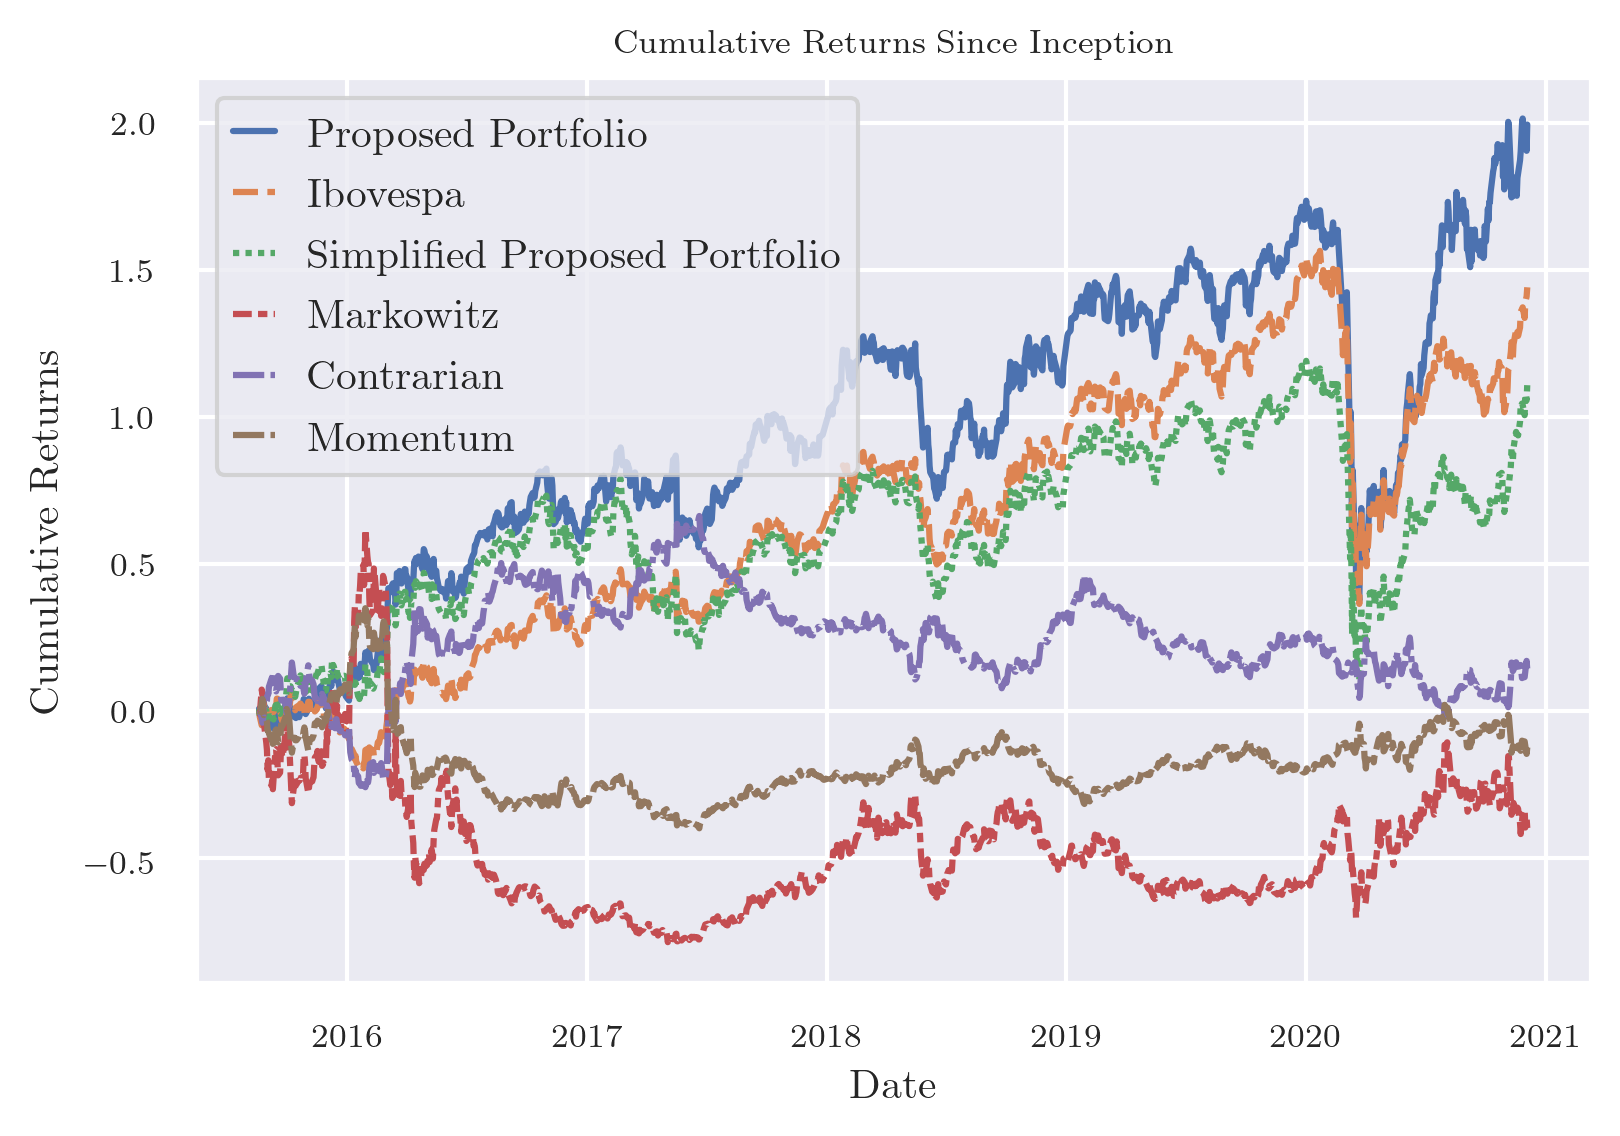

In [8]:
n_stats = 27
n_fundos = 6
df_stats = pd.DataFrame(data = np.zeros([n_stats,n_fundos]),
                        index = ['Mean', 'Vol','Min','Perc_25', 'Perc_50', 'Perc_75', 
                                 'Max','Range','Skew','Kurt','VolHistAnual',
                                 'Vol LTM', 'Sharpe LTM', 'Sharpe Hist',
                                 'MaxDD', 'VaR Hist','VaR NonPar','CVaR_Hist', 'CVaR NonPar','Omega',
                                 '% Ret Pos', '% Ret Neg',
                                 '% Ret Exc Pos', '% Ret Exc Neg', 'Ret Min', 'Ret Max', 'Beta'],
                                        columns = ['Brandt', 'Brandt_Direto', 'Markowitz', 'Contrarian','Ibove','Momentum'])

for j in range(0,6):
    if j == 0:
        df_fundo_log_retorno = df_Brandt
    elif j == 1:
        df_fundo_log_retorno = df_Brandt_Direto 
    elif j == 2:
        df_fundo_log_retorno = df_Markowitz 
    elif j == 3:
        df_fundo_log_retorno = df_Contrarian
    elif j == 4:
        df_fundo_log_retorno = df_ibove_log_retorno
    else:
        df_fundo_log_retorno = df_Momentum
        
        
    df_fundo_retorno = np.exp(df_fundo_log_retorno)-1
    
    df_fundo_log_retorno_acum = df_fundo_log_retorno.cumsum()
    df_fundo_retorno_acum = np.exp(df_fundo_log_retorno_acum)-1
    
    # Principais estatísticas (retornos discretos diários)
    i = 0
    df_stats.iloc[i,j] = np.mean(np.array(df_fundo_retorno))
    
    i = i + 1
    df_stats.iloc[i,j] = np.std(np.array(df_fundo_retorno), ddof = 1)

    i = i + 1
    df_stats.iloc[i,j] = np.min(np.array(df_fundo_retorno))

    i = i + 1
    df_stats.iloc[i,j] = np.percentile(np.array(df_fundo_retorno), 25, axis = 0)
    
    i = i + 1
    df_stats.iloc[i,j] = np.percentile(np.array(df_fundo_retorno), 50, axis = 0)
    
    i = i + 1   
    df_stats.iloc[i,j] = np.percentile(np.array(df_fundo_retorno), 75, axis = 0)

    i = i + 1
    df_stats.iloc[i,j] = np.max(np.array(df_fundo_retorno))

    i = i + 1
    df_stats.iloc[i,j] = np.max(np.array(df_fundo_retorno)) - np.min(np.array(df_fundo_retorno))

    i = i + 1
    df_stats.iloc[i,j] = sp.stats.skew(np.array(df_fundo_retorno))

    i = i + 1
    df_stats.iloc[i,j] = sp.stats.kurtosis(np.array(df_fundo_retorno))
  
    i = i + 1
    df_stats.iloc[i,j] = np.std(np.array(df_fundo_retorno), ddof = 1)*np.sqrt(252)

    i = i + 1
    df_stats.iloc[i,j] = np.std(np.array(df_fundo_retorno.tail(252)), ddof = 1)*np.sqrt(252)

    i = i + 1
    df_stats.iloc[i,j] = ((((1+np.mean(np.array(df_fundo_retorno.tail(252))))**252-1) - ((1+np.mean(np.array(df_cdi_retorno.tail(252))))**252-1))) / (np.std(np.array(df_fundo_retorno.tail(252)), ddof = 1)*np.sqrt(252))
    #df_stats.iloc[i,j] = ((np.exp((np.sum(df_fundo_log_retorno.tail(252))))-1)-(np.exp((np.sum(df_cdi_log_retorno.tail(252))))-1)) / (np.std(np.array(df_fundo_retorno.tail(252)), ddof = 1)*np.sqrt(252))
    
    i = i + 1
    df_stats.iloc[i,j] = ((((1+np.mean(np.array(df_fundo_retorno)))**252-1) - ((1+np.mean(np.array(df_cdi_retorno)))**252-1))) / (np.std(np.array(df_fundo_retorno), ddof = 1)*np.sqrt(252))
    #df_stats.iloc[i,j] = ((np.exp((np.sum(df_fundo_log_retorno)))-1)-(np.exp((np.sum(df_cdi_log_retorno)))-1)) / (np.std(np.array(df_fundo_retorno), ddof = 1)*np.sqrt(252))

    i = i + 1
    df_stats.iloc[i,j] = MaxDD(df_fundo_retorno_acum)[0]

    i = i + 1
    df_stats.iloc[i,j] = VaR_Hist(df_fundo_retorno, 0.05)

    i = i + 1
    df_stats.iloc[i,j] = VaR_NonPar(df_fundo_retorno, 0.05, 1000).iloc[0,0]

    i = i + 1
    df_stats.iloc[i,j] = CVaR_Hist(df_fundo_retorno, 0.05)[0]
    
    i = i + 1
    df_stats.iloc[i,j] = CVaR_NonPar(df_fundo_retorno, 0.05, 1000).iloc[0,0]

    i = i + 1
    df_stats.iloc[i,j] = Omega(df_fundo_retorno, np.mean(df_cdi_retorno)[0], 1000).iloc[0,0]

    i = i + 1
    df_stats.iloc[i,j] = np.array(df_fundo_retorno[df_fundo_retorno>0].count() / df_fundo_retorno.count())

    i = i + 1
    df_stats.iloc[i,j] = 1 - (np.array(df_fundo_retorno[df_fundo_retorno>0].count() / df_fundo_retorno.count()))
    
    i = i + 1
    df_stats.iloc[i,j] = ((pd.DataFrame(np.array(df_fundo_retorno) - np.array(df_cdi_retorno), index = df_fundo_retorno.index))[(pd.DataFrame(np.array(df_fundo_retorno) - np.array(df_cdi_retorno), index = df_fundo_retorno.index))>0].count() / (pd.DataFrame(np.array(df_fundo_retorno) - np.array(df_cdi_retorno), index = df_fundo_retorno.index)).count())[0]

    i = i + 1
    df_stats.iloc[i,j] = 1 - (((pd.DataFrame(np.array(df_fundo_retorno) - np.array(df_cdi_retorno), index = df_fundo_retorno.index))[(pd.DataFrame(np.array(df_fundo_retorno) - np.array(df_cdi_retorno), index = df_fundo_retorno.index))>0].count() / (pd.DataFrame(np.array(df_fundo_retorno) - np.array(df_cdi_retorno), index = df_fundo_retorno.index)).count())[0])
    
    i = i + 1
    df_stats.iloc[i,j] = (np.min(np.array(df_fundo_retorno)))
    
    i = i + 1
    df_stats.iloc[i,j] = (np.max(np.array(df_fundo_retorno)))    

    i = i + 1
    df_stats.iloc[i,j] = calc_beta(df_fundo_retorno, df_ibove_log_retorno)
    
df_stats.to_csv(str_dir + 'Tabela Resultados.csv')

# Gráfico dos retornos acumulados
plt.rc('xtick', labelsize=8) 
df_Brandt_retorno_acum = np.exp(df_Brandt.cumsum())-1
df_ibove_acum = df_ibove_retorno_acum
df_Brandt_Direto_acum = np.exp(df_Brandt_Direto.cumsum())-1
df_Markowitz_acum = np.exp(df_Markowitz.cumsum())-1
df_Contrarian_acum = np.exp(df_Contrarian.cumsum())-1
df_Momentum_acum = np.exp(df_Momentum.cumsum())-1
    
df_retornos = pd.concat([df_Brandt_retorno_acum, df_ibove_acum, df_Brandt_Direto_acum, df_Markowitz_acum,
                       df_Contrarian_acum, df_Momentum_acum], axis = 1)
df_retornos.columns = ["Proposed Portfolio", "Ibovespa", "Simplified Proposed Portfolio", 
                       "Markowitz", "Contrarian", "Momentum"]
ax = sns.lineplot(data = df_retornos)
ax.set_ylabel("Cumulative Returns")
ax.set_xlabel("Date")
ax.set_title("Cumulative Returns Since Inception")


Text(0.5, 1.0, '63-day Rolling Window Volatility')

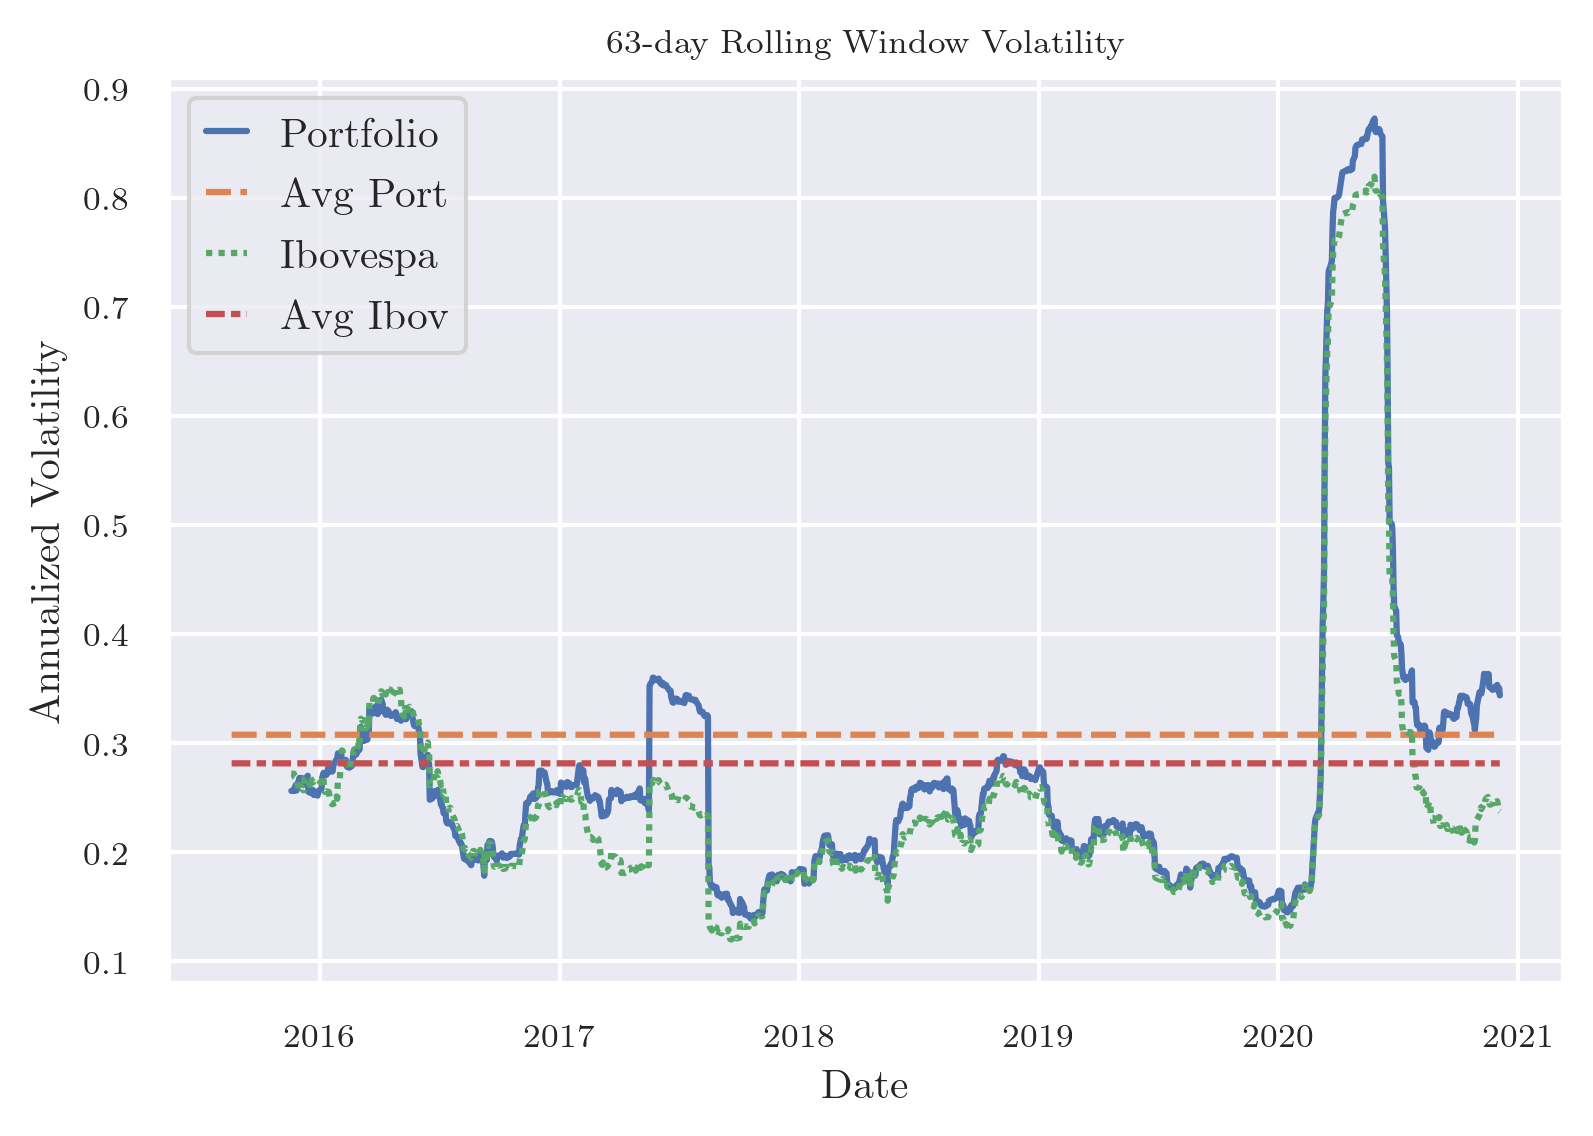

In [10]:
# Volatilidade em janelas móveis de 3 meses - Brandt
du = 63
vol = df_Brandt.rolling(du).std(ddof=1)*np.sqrt(252)
vol.columns = ["Portfolio"]
vol_hist = np.std(np.array(df_Brandt), ddof = 1)*np.sqrt(252)
vol["Avg Port"] = np.repeat(vol_hist, vol.shape[0])
vol["Ibovespa"] = df_ibove_log_retorno.rolling(du).std(ddof=1)*np.sqrt(252)
vol["Avg Ibov"] = np.repeat(np.std(np.array(df_ibove_log_retorno), ddof = 1)*np.sqrt(252), vol.shape[0])
ax = sns.lineplot(data = vol)
ax.set_ylabel("Annualized Volatility")
ax.set_xlabel("Date")
ax.set_title(str(du)+"-day Rolling Window Volatility")

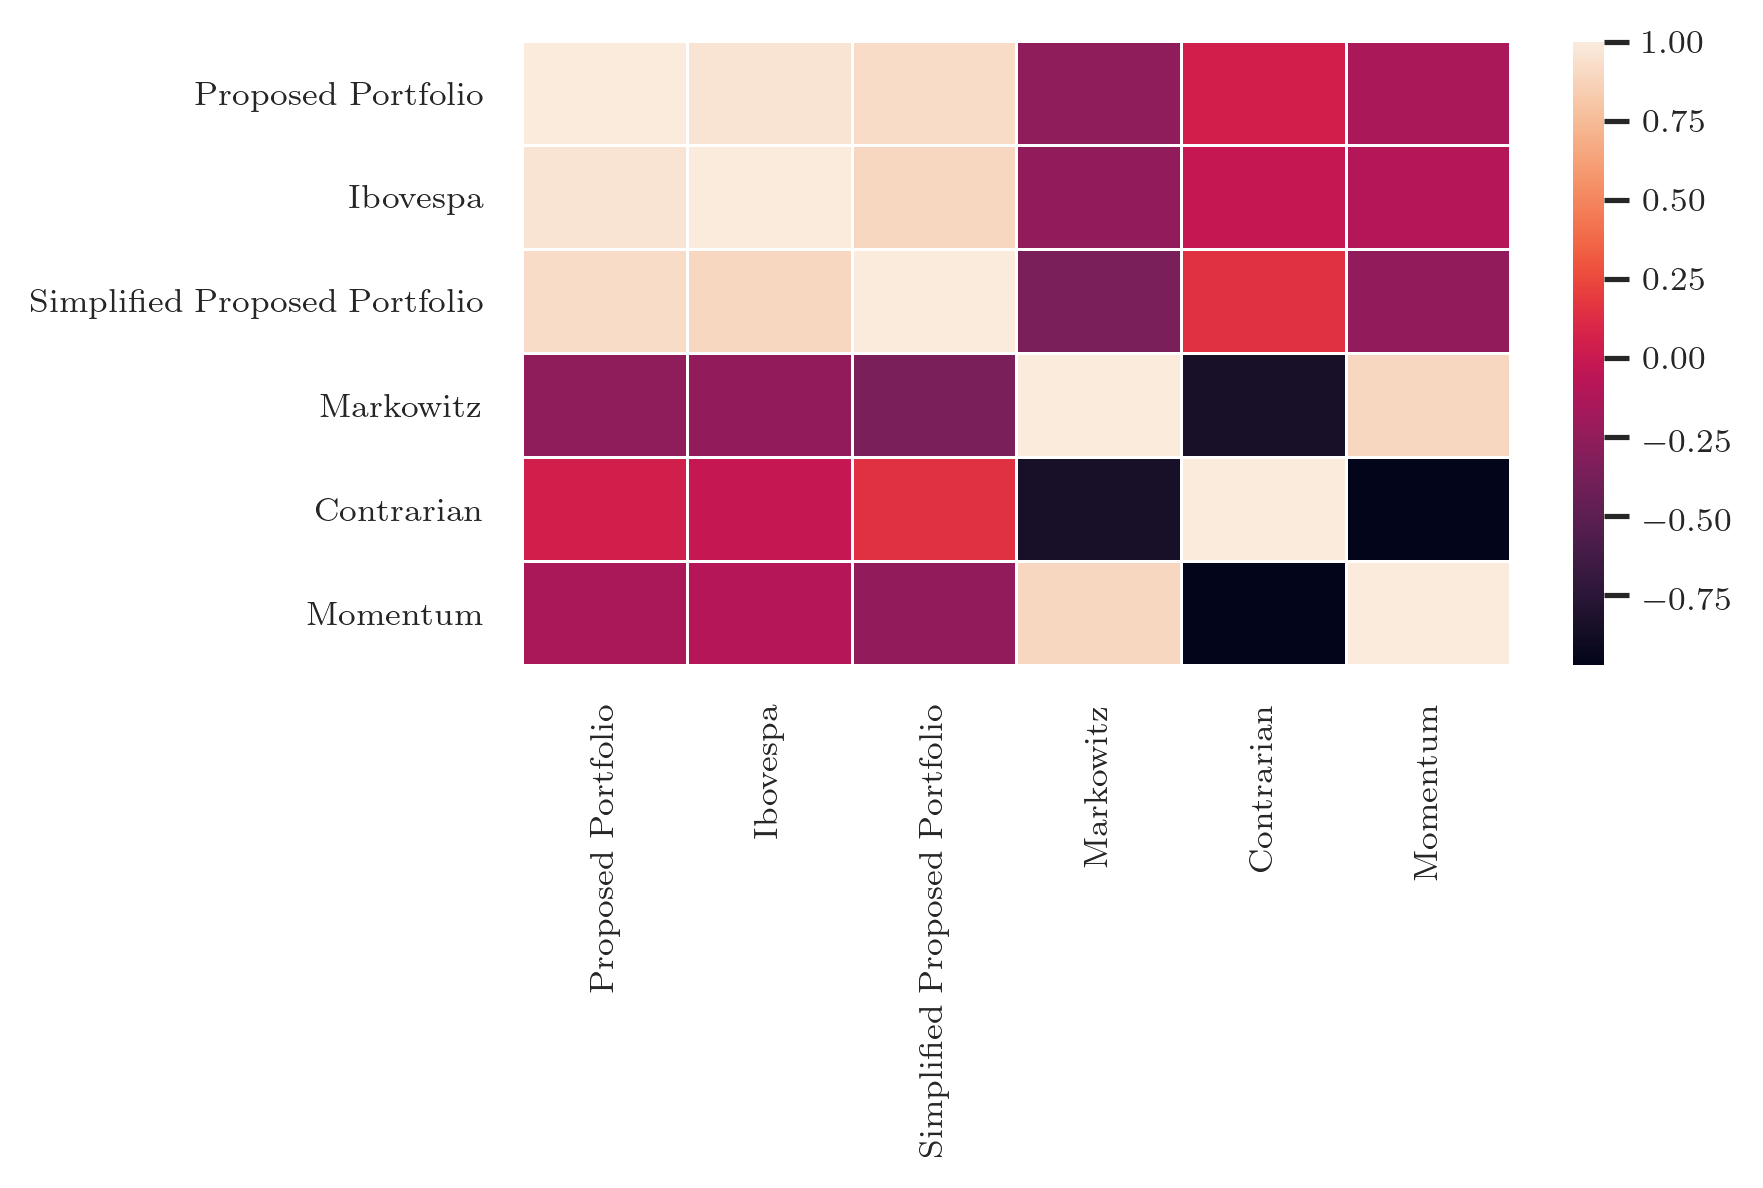

In [11]:
# Matriz de Correlação e Heatmap
df_correl = df_retornos.corr()
df_correl.to_clipboard()
sns.heatmap(df_retornos.corr(), linewidth = 0.5)
plt.tight_layout()